**CLASS DEFINITION**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

class SingleLayerPerceptron:
    def __init__(self, learning_rate=0.1, epochs=5, initial_weight=0.5):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.initial_weight = initial_weight
        self.weights = None
        self.bias = None

        # Training history
        self.train_accuracy_history = []
        self.train_loss_history = []
        self.val_accuracy_history = []
        self.val_loss_history = []

    def initialize_weights(self, n_features):
        """Initialize weights and bias with specified initial value"""
        self.weights = np.full(n_features, self.initial_weight, dtype=float)
        self.bias = self.initial_weight

    def activation_function(self, z):
        """Sigmoid activation function"""
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def forward_pass(self, X):
        """Forward pass through the network"""
        z = np.dot(X, self.weights) + self.bias
        return self.activation_function(z)

    def compute_mse_loss(self, y_true, y_pred):
        """Compute Mean Square Error loss"""
        return np.mean((y_true - y_pred) ** 2)

    def compute_accuracy(self, y_true, y_pred):
        """Compute classification accuracy"""
        y_pred_binary = (y_pred >= 0.5).astype(int)
        return np.mean(y_true == y_pred_binary)

    def fit(self, X_train, y_train, X_val, y_val):
        """Train the Single Layer Perceptron with validation"""
        n_samples, n_features = X_train.shape
        self.initialize_weights(n_features)

        print(f"Training SLP with {n_samples} training samples and {len(X_val)} validation samples")
        print(f"Features: {n_features}")
        print(f"Initial weights: {self.weights}")
        print(f"Initial bias: {self.bias}")
        print("-" * 80)

        for epoch in range(self.epochs):
            # Training - Forward pass
            y_train_pred = self.forward_pass(X_train)

            # Training metrics
            train_loss = self.compute_mse_loss(y_train, y_train_pred)
            train_accuracy = self.compute_accuracy(y_train, y_train_pred)

            # Validation - Forward pass (no training)
            y_val_pred = self.forward_pass(X_val)
            val_loss = self.compute_mse_loss(y_val, y_val_pred)
            val_accuracy = self.compute_accuracy(y_val, y_val_pred)

            # Store metrics
            self.train_loss_history.append(train_loss)
            self.train_accuracy_history.append(train_accuracy)
            self.val_loss_history.append(val_loss)
            self.val_accuracy_history.append(val_accuracy)

            # Compute gradients (only on training data)
            error = y_train_pred - y_train

            # Update weights and bias using gradient descent
            weight_gradient = np.dot(X_train.T, error) / n_samples
            bias_gradient = np.mean(error)

            self.weights -= self.learning_rate * weight_gradient
            self.bias -= self.learning_rate * bias_gradient

            print(f"Epoch {epoch + 1}/{self.epochs}")
            print(f"  Train - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
            print(f"  Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
            print("-" * 50)

        print("Training completed!")

    def predict(self, X):
        """Make predictions"""
        y_pred = self.forward_pass(X)
        return (y_pred >= 0.5).astype(int)

    def predict_proba(self, X):
        """Predict probabilities"""
        return self.forward_pass(X)

**LOAD** **DATA**

In [2]:
file_path = "datasetiris.xlsx"
df = pd.read_excel(file_path)

print(f"Dataset loaded from: {file_path}")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

print(f"\nDataset Info:")
print(df.info())

print(f"\nClass distribution:")
if 'species' in df.columns:
    print(df['species'].value_counts())
elif df.columns[-1] in df.select_dtypes(include=['object']).columns:
    print(df[df.columns[-1]].value_counts())

print("First 5 rows:")
print(df.head())

print("\nLast 5 rows:")
print(df.tail())

Dataset loaded from: datasetiris.xlsx
Dataset shape: (100, 5)
Columns: ['COL1', 'COL2', 'COL3', 'COL4', 'TARGET']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   COL1    100 non-null    float64
 1   COL2    100 non-null    float64
 2   COL3    100 non-null    float64
 3   COL4    100 non-null    float64
 4   TARGET  100 non-null    object 
dtypes: float64(4), object(1)
memory usage: 4.0+ KB
None

Class distribution:
TARGET
Iris-setosa        50
Iris-versicolor    50
Name: count, dtype: int64
First 5 rows:
   COL1  COL2  COL3  COL4       TARGET
0   5.1   3.5   1.4   0.2  Iris-setosa
1   4.9   3.0   1.4   0.2  Iris-setosa
2   4.7   3.2   1.3   0.2  Iris-setosa
3   4.6   3.1   1.5   0.2  Iris-setosa
4   5.0   3.6   1.4   0.2  Iris-setosa

Last 5 rows:
    COL1  COL2  COL3  COL4           TARGET
95   5.7   3.0   4.2   0.2  Iris-versicolor
96  

**PREPROCESSING**

In [3]:
# Identify target and feature columns
target_column = df.columns[-1]
feature_columns = [col for col in df.columns if col != target_column]

print(f"Target column: {target_column}")
print(f"Feature columns: {feature_columns}")

# Extract features and target
X = df[feature_columns].values
y = df[target_column].values

print(f"\nOriginal data shapes:")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

# Encode target variable for binary classification
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Check classes
unique_classes = np.unique(y_encoded)
class_names = le.classes_

print(f"\nTarget encoding:")
print(f"Original classes: {class_names}")
print(f"Encoded classes: {unique_classes}")
print(f"Class mapping: {dict(zip(class_names, unique_classes))}")

print(f"\nFinal data for binary classification:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}")
print(f"Classes: {class_names}")
print(f"Class distribution: {np.bincount(y_encoded)}")

# Split data (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")


# Standardize features
print(f"\nStandardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Data preprocessing completed!")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Validation set shape: {X_val_scaled.shape}")

Target column: TARGET
Feature columns: ['COL1', 'COL2', 'COL3', 'COL4']

Original data shapes:
Features (X): (100, 4)
Target (y): (100,)

Target encoding:
Original classes: ['Iris-setosa' 'Iris-versicolor']
Encoded classes: [0 1]
Class mapping: {'Iris-setosa': 0, 'Iris-versicolor': 1}

Final data for binary classification:
Features shape: (100, 4)
Target shape: (100,)
Classes: ['Iris-setosa' 'Iris-versicolor']
Class distribution: [50 50]
Training set: 80 samples
Validation set: 20 samples

Standardizing features...
Data preprocessing completed!
Training set shape: (80, 4)
Validation set shape: (20, 4)


**MODEL TRAINING**

In [4]:
# Model configuration
learning_rate = 0.1
epochs = 5
initial_weight = 0.5

# Create and train model
slp = SingleLayerPerceptron(
    learning_rate=learning_rate,
    epochs=epochs,
    initial_weight=initial_weight
)

slp.fit(X_train_scaled, y_train, X_val_scaled, y_val)

# Print detailed metrics table
print("\n" + "="*60)
print("DETAILED TRAINING METRICS")
print("="*60)

print(f"{'Epoch':<8} {'Train Loss':<12} {'Train Acc':<12} {'Val Loss':<12} {'Val Acc':<12}")
print("-" * 60)

for epoch in range(len(slp.train_accuracy_history)):
    train_loss = slp.train_loss_history[epoch]
    train_acc = slp.train_accuracy_history[epoch]
    val_loss = slp.val_loss_history[epoch]
    val_acc = slp.val_accuracy_history[epoch]

    print(f"{epoch+1:<8} {train_loss:<12.4f} {train_acc:<12.4f} {val_loss:<12.4f} {val_acc:<12.4f}")

# Final evaluation
print("\n" + "="*60)
print("FINAL MODEL EVALUATION")
print("="*60)

final_train_acc = slp.train_accuracy_history[-1]
final_train_loss = slp.train_loss_history[-1]
final_val_acc = slp.val_accuracy_history[-1]
final_val_loss = slp.val_loss_history[-1]

print(f"Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Final Validation Loss: {final_val_loss:.4f}")

print(f"\nFinal Model Parameters:")
print(f"Weights: {slp.weights}")
print(f"Bias: {slp.bias}")

Training SLP with 80 training samples and 20 validation samples
Features: 4
Initial weights: [0.5 0.5 0.5 0.5]
Initial bias: 0.5
--------------------------------------------------------------------------------
Epoch 1/5
  Train - Loss: 0.1809, Accuracy: 0.7125
  Val   - Loss: 0.2063, Accuracy: 0.6500
--------------------------------------------------
Epoch 2/5
  Train - Loss: 0.1674, Accuracy: 0.7625
  Val   - Loss: 0.1936, Accuracy: 0.6500
--------------------------------------------------
Epoch 3/5
  Train - Loss: 0.1550, Accuracy: 0.8125
  Val   - Loss: 0.1818, Accuracy: 0.7000
--------------------------------------------------
Epoch 4/5
  Train - Loss: 0.1436, Accuracy: 0.8125
  Val   - Loss: 0.1708, Accuracy: 0.7000
--------------------------------------------------
Epoch 5/5
  Train - Loss: 0.1332, Accuracy: 0.8375
  Val   - Loss: 0.1607, Accuracy: 0.7000
--------------------------------------------------
Training completed!

DETAILED TRAINING METRICS
Epoch    Train Loss   Train 

**VISUALISASI**

C:\Users\HP\AppData\Local\Temp\ipykernel_15372\677283806.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(epochs, slp.train_accuracy_history, 'b-o', linewidth=2, markersize=6,
C:\Users\HP\AppData\Local\Temp\ipykernel_15372\677283806.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-s" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(epochs, slp.val_accuracy_history, 'r-s', linewidth=2, markersize=6,
C:\Users\HP\AppData\Local\Temp\ipykernel_15372\677283806.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(epochs, slp.train_loss_history, 'b-o', linewidth=2, markersize=6,
C:\Users\HP\AppData\Local\Temp\ipykernel_15372\677283806.py:27: UserWarning: color is redundantly 

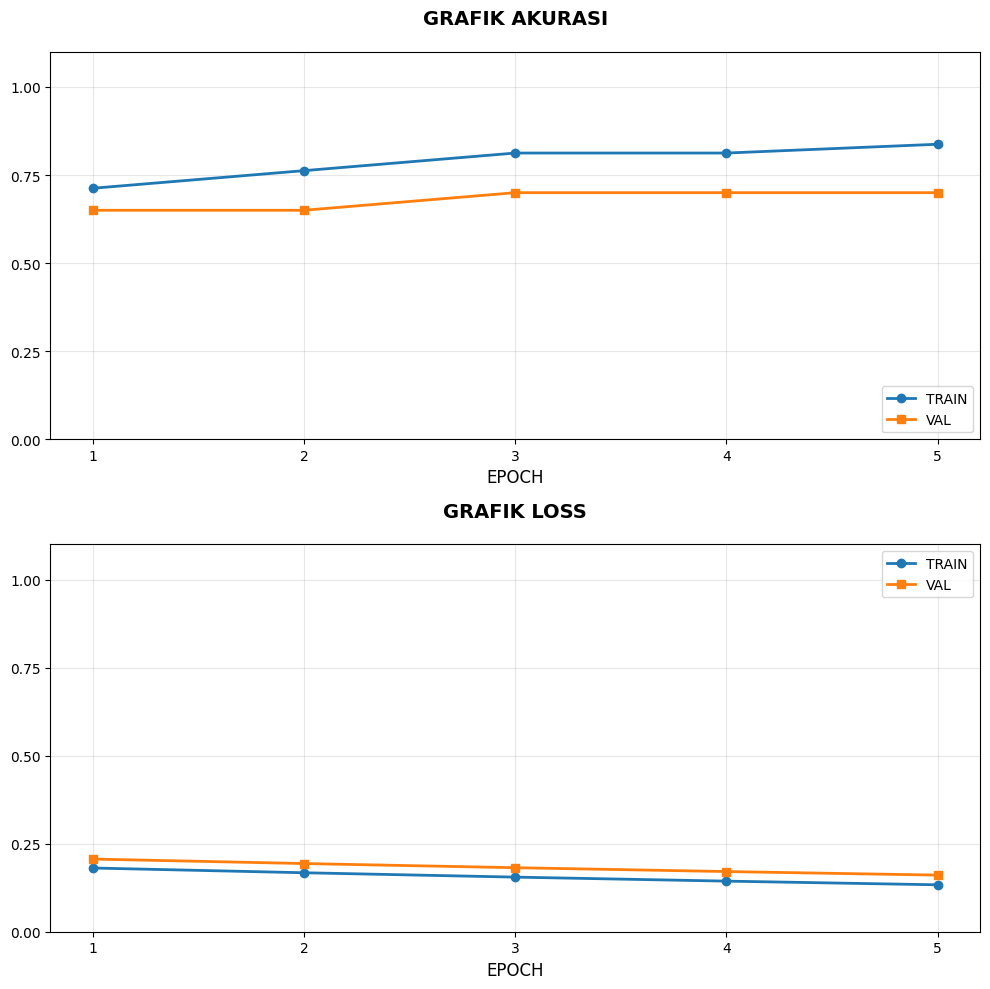

In [5]:
# Create training metrics plots
epochs = range(1, len(slp.train_accuracy_history) + 1)

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot 1: GRAFIK AKURASI
ax1.plot(epochs, slp.train_accuracy_history, 'b-o', linewidth=2, markersize=6,
         label='TRAIN', color='#1f77b4')
ax1.plot(epochs, slp.val_accuracy_history, 'r-s', linewidth=2, markersize=6,
         label='VAL', color='#ff7f0e')

ax1.set_title('GRAFIK AKURASI', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('EPOCH', fontsize=12)
ax1.set_ylabel('', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.1)
ax1.set_xticks(epochs)

# Set y-axis ticks
ax1.set_yticks([0.00, 0.25, 0.50, 0.75, 1.00])

# Plot 2: GRAFIK LOSS
ax2.plot(epochs, slp.train_loss_history, 'b-o', linewidth=2, markersize=6,
         label='TRAIN', color='#1f77b4')
ax2.plot(epochs, slp.val_loss_history, 'r-s', linewidth=2, markersize=6,
         label='VAL', color='#ff7f0e')

ax2.set_title('GRAFIK LOSS', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('EPOCH', fontsize=12)
ax2.set_ylabel('', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(epochs)

# Set y-axis ticks for loss
ax2.set_yticks([0.00, 0.25, 0.50, 0.75, 1.00])
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()